In [839]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [575]:
## fit the model
def fit_model(model,X_train,y_train,X_test,y_test):
    model_cv_score = cross_val_score(model,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

    model.fit(X_train,y_train)
    
    
    y_test_pred = model.predict(X_test)
    y_test_pro = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)

    print("Mean_accuracy_cv:\t" + str(np.mean(model_cv_score)))
    print("Test_accuracy:\t" + str(acc))
    print("Test_F1:\t" + str(f1))
   
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pro[:,1])
    auc = roc_auc_score(y_test, y_test_pro[:,1])
    print("Test_auc:\t" + str(auc))
    return fpr, tpr, thresholds

## 2.1  Merge and convert all to numerical

In [83]:
## input data
patient_data = pd.read_csv("modify_patient_data_2.csv",index_col=0)
mrna_data = pd.read_csv("modify_mrna_data.csv",index_col=0)
seq_data = pd.read_csv("modify_seq_data.csv",index_col=0)

## modify column names
seq_data.columns = ["mu_"+a for a in seq_data.columns]
patient_data.index = [a+"-01" for a in patient_data.index]

### Heatmap of genes expression

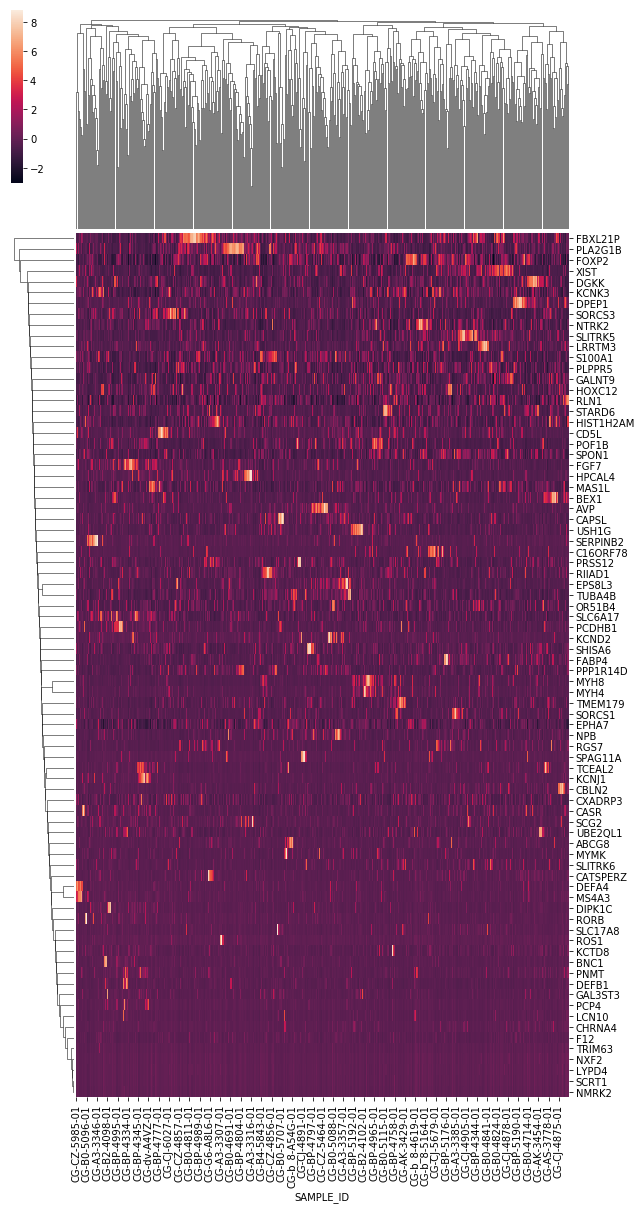

In [84]:
cm=sns.clustermap(mrna_data.T,z_score=True, 
             square=False, figsize = (10,20));          # , figsize = (10,20))         
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)   # rotate ticks
plt.show() 

In [734]:
## merge three files
two_seq = pd.merge(mrna_data,seq_data,left_index=True,right_index=True)
three_com = pd.merge(two_seq,patient_data,left_index=True,right_index=True)

## convert race and age to numerical
race = pd.get_dummies(three_com['Race Category']).iloc[:,:-1]
age = pd.get_dummies(three_com['Diagnosis Age 2']).iloc[:,:-1]

y = three_com['classes']
three_com = three_com.drop(['Race Category','Diagnosis Age 2','classes'],1)
X = pd.concat([three_com,race,age],1)

## split train and test
y = (y == "high").astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


In [880]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
1- y.mean()
X.shape

(432, 134)

## 2.2 Draft modeling

In [736]:
d_y = Counter(y_test.tolist())
score = d_y[0]/np.sum(list(d_y.values()))
print("Dummy_classifer (only preidect the highest abundant class)")
print("Accuracy: {:0.2f}".format(score))


Dummy_classifer (only preidect the highest abundant class)
Accuracy: 0.62


In [737]:
## Bayesian classifer can handle arbitary number of indenpendant feartures.
## no influence from high dimensionality, so it was selected as our first model

# bayG = GaussianNB()
# scores = cross_validate(bayG,X_train_scale,y_train,cv=5,scoring='accuracy')
# print("GaussianNB")
# print("Accuracy: {:0.2f}".format(scores['test_score'].mean()))

# bayM = MultinomialNB()
# scores = cross_validate(bayM,X_train_scale,y_train,cv=5,scoring='accuracy')
# print("MultinomialNB")
# print("Accuracy: {:0.2f}".format(scores['test_score'].mean()))

bayB = BernoulliNB()
scores = cross_validate(bayB,X_train_scale,y_train,cv=5,scoring='accuracy')
print("BernoulliNB")
print("Accuracy: {:0.2f}".format(scores['test_score'].mean()))
print("Only slightly better than Dummy_classifer")

BernoulliNB
Accuracy: 0.69
Only slightly better than Dummy_classifer


In [738]:
bayB = BernoulliNB()
bayB.fit(X_train_scale,y_train)
y_test_pred = bayB.predict(X_test_scale)
accuracy_score(y_test,y_test_pred)

0.7222222222222222

In [739]:
train_scores = []
test_scores = []
n_estimator = [100,200,400,800,1500,3000]
for n in n_estimator:
    rfc = RandomForestClassifier(n_estimators=n)
    scores = cross_validate(rfc,X_train_scale,y_train,cv=5,scoring='accuracy')
    train_scores.append(scores['train_score'].mean())
    test_scores.append(scores['test_score'].mean())

(0, 0.8)

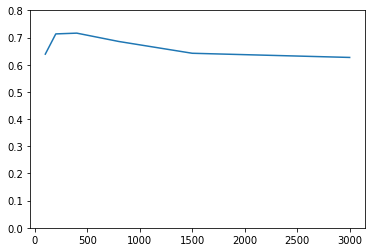

In [848]:
plt.plot(n_estimator,test_scores)
plt.ylim([0,0.8])

In [851]:
rfc = RandomForestClassifier(n_estimators=3000)
#svm.fit(X_train_sel_lr,y_train)
rfc.fit(X_train_scale,y_train)
y_test_pred = rfc.predict(X_test_scale)
accuracy_score(y_test,y_test_pred)

0.7314814814814815

In [852]:
rfc = RandomForestClassifier(n_estimators=3000)
fpr_rfc, tpr_rfc, thresholds_rfc = fit_model(rfc,X_train_scale,y_train,X_test_scale, y_test)


Mean_accuracy_cv:	0.7191358024691358
Test_accuracy:	0.7222222222222222
Test_F1:	0.5454545454545455
Test_auc:	0.7877684746996724


In [742]:
bayB = BernoulliNB()
scores = cross_validate(bayB,X_train_scale,y_train,cv=5,scoring='accuracy')
print("BernoulliNB")
print("Accuracy: {:0.2f}".format(scores['test_score'].mean()))


BernoulliNB
Accuracy: 0.69


In [743]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
scores = cross_validate(svm,X_train_scale,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.6666807813911473

In [744]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='adam', alpha=10, hidden_layer_sizes=(5, 2), max_iter=1000)

scores = cross_validate(nn,X_train_scale,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.6732356594399277

In [847]:
nn = MLPClassifier(solver='adam', alpha=21, hidden_layer_sizes=(5, 2), max_iter=1000)
nn.fit(X_train_scale,y_train)
y_test_pred = nn.predict(X_test_scale)
accuracy_score(y_test,y_test_pred)

0.6203703703703703

## 2.3 Feature selection
## 2.3.1 filter features not important using l1 norm then modeling

In [746]:
train_scores = []
test_scores = []
Cs = [0.01,0.1,1,10,100,1000]
for c in Cs:
    lr = LogisticRegression(C=c,penalty='l1')
    scores = cross_validate(lr,X_train_scale,y_train,cv=5,scoring='accuracy')
    train_scores.append(scores['train_score'].mean())
    test_scores.append(scores['test_score'].mean())

[0.6389204545454545,
 0.7133522727272726,
 0.7161931818181818,
 0.6855113636363637,
 0.6421401515151516,
 0.6267992424242423]

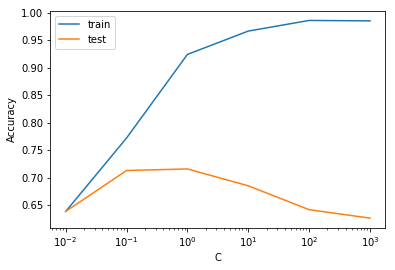

In [747]:
plt.plot(Cs,train_scores,label='train')
plt.plot(Cs,test_scores,label='test')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()

plt.xscale('log')
test_scores

In [748]:
lr = LogisticRegression(C=0.1,penalty='l1')
lr.fit(X_train_scale,y_train)
y_test_pred = lr.predict(X_test_scale)
print("% of features with weights of 0: {:0.2f}".format((lr.coef_ == 0).mean()))


% of features with weights of 0: 0.71


In [749]:
lr_coef = pd.DataFrame(lr.coef_)
lr_coef.columns = X_train.columns
select_features = lr_coef.loc[:,lr_coef.iloc[0,:] != 0].columns
# select_features = lr_coef.max().nlargest(0).index
X_train_sel_lr = pd.DataFrame(X_train_scale,columns=X_test.columns).loc[:,select_features]
X_test_sel_lr = pd.DataFrame(X_test_scale,columns=X_test.columns).loc[:,select_features]


rfc = RandomForestClassifier(n_estimators=3000)
scores = cross_validate(rfc,X_train_sel_lr,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.7314617208672087

In [840]:
rfc = RandomForestClassifier(n_estimators=3000)
fpr_rfc_l1, tpr_rfc_l1, thresholds_rfc_l1 = fit_model(rfc,X_train_sel_lr,y_train,X_test_sel_lr, y_test)


Mean_accuracy_cv:	0.70679012345679
Test_accuracy:	0.7314814814814815
Test_F1:	0.5797101449275363
Test_auc:	0.7717510010921005


In [751]:
svm = SVC(kernel='linear')
scores = cross_validate(svm,X_train_sel_lr,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.765602416440831

In [752]:
svm = SVC(kernel='linear')
#svm.fit(X_train_sel_lr,y_train)
svm.fit(X_train_sel_lr,y_train)
y_test_pred = svm.predict(X_test_sel_lr)
accuracy_score(y_test,y_test_pred)

0.7037037037037037

In [753]:
nn = MLPClassifier(solver='adam', alpha=10, hidden_layer_sizes=(10, 4), max_iter=1000)
nn.fit(X_train_sel_lr,y_train)

scores = cross_validate(nn,X_train_sel_lr,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.7284891598915989

In [836]:
nn = MLPClassifier(solver='adam', alpha=10, hidden_layer_sizes=(10, 4), max_iter=1000)
fpr_nn_l1, tpr_nn_l1, thresholds_nn_l1 = fit_model(nn,X_train_sel_lr,y_train,X_test_sel_lr, y_test)


Mean_accuracy_cv:	0.6388888888888888
Test_accuracy:	0.7407407407407407
Test_F1:	0.6111111111111112
Test_auc:	0.7397160538769567


## 2.3.2 PCA reduce dimensionality then modeling

[9.84044894e-01 5.24992697e-03 7.27736866e-04 5.65608088e-04
 5.10074320e-04 4.60235600e-04 4.05974478e-04 3.33191978e-04
 3.22697546e-04 3.15447317e-04]


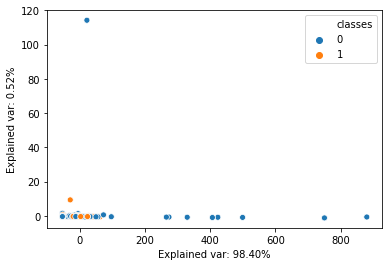

In [755]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
sns.scatterplot(x=X_train_pca[:,0],y=X_train_pca[:,1],hue=y_train)
plt.xlabel("Explained var: {:0.2f}%".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("Explained var: {:0.2f}%".format(pca.explained_variance_ratio_[1]*100))
print(pca.explained_variance_ratio_)

In [756]:
rfc = RandomForestClassifier(n_estimators=1000)
scores = cross_validate(rfc,X_train_pca,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.6357761216501053

In [795]:
svm = SVC(kernel='linear')
scores = cross_validate(svm,X_train_pca,y_train,cv=4,scoring='accuracy',n_jobs=-1)
scores['test_score'].mean()

0.6544480201746462

In [814]:
lr = LogisticRegression(C=10)
scores = cross_validate(lr,X_train_pca,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.6605079418849744

In [816]:
gbc = GradientBoostingClassifier(n_estimators=300)
scores = cross_validate(gbc,X_train_pca,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.6300201370069256

In [821]:
nn = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(10, 4), max_iter=10000)
#nn.fit(X_train_tem,y_train)
scores = cross_validate(nn,X_train_pca,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.6265535606744956

## 2.3.3 LinearDiscriminantAnalysis reduce dimensionality then modeling


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline


lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit()


In [ ]:
rfc = RandomForestClassifier(n_estimators=2000)
pipline = Pipeline([('lda', lda), ('rfc', rfc)])
scores = cross_validate(pipline,X_train_scale,y_train,cv=5,scoring='accuracy')
scores['test_score'].mean()

In [824]:
svm = SVC(kernel='linear')
pipline = Pipeline([('lda', lda), ('svm', svm)])
scores = cross_validate(pipline,X_train_scale,y_train,cv=5,scoring='accuracy')
scores['test_score'].mean()

0.6696022727272728

In [833]:
lr = LogisticRegression(C=0.1)
pipline = Pipeline([('lda', lda), ('lr', lr)])
scores = cross_validate(pipline,X_train_scale,y_train,cv=5,scoring='accuracy')
scores['test_score'].mean()

0.6757575757575758

In [834]:
gbc = GradientBoostingClassifier(n_estimators=300)
pipline = Pipeline([('lda', lda), ('gbc', gbc)])
scores = cross_validate(pipline,X_train_scale,y_train,cv=5,scoring='accuracy')
scores['test_score'].mean()

0.6636363636363637

## 2.3.3 Pick features with top correlation aganist two classes then modeling

In [856]:
df_col = pd.DataFrame(X_train_scale,columns=X_train.columns)
df_col["classes"] = list(y_train)#.str.replace("low","0").str.replace("medium","1").str.replace("high","2").astype(int))

n = 20
largest_idx = df_col.corr(method="spearman")['classes'].nlargest(n+1).index[1:]
smallest_idx = df_col.corr(method="spearman")['classes'].nsmallest(n).index

both_idx = list(largest_idx) + list(smallest_idx)

X_train_tem = pd.DataFrame(X_train_scale, columns=X_train.columns).loc[:,both_idx]
X_test_tem = pd.DataFrame(X_test_scale, columns=X_train.columns).loc[:,both_idx]

In [857]:
rfc = RandomForestClassifier(n_estimators=3000)
scores = cross_validate(rfc,X_train_tem,y_train,cv=4,scoring='accuracy',n_jobs=-1)
scores['test_score'].mean()

0.7345453176753989

In [858]:
rfc = RandomForestClassifier(n_estimators=3000)
fpr_rfc_cor, tpr_rfc_cor, thresholds_rfc_cor = fit_model(rfc,X_train_tem,y_train,X_test_tem, y_test)


Mean_accuracy_cv:	0.7098765432098766
Test_accuracy:	0.7870370370370371
Test_F1:	0.684931506849315
Test_auc:	0.7950491445212959


In [859]:
svm = SVC(kernel='linear')
scores = cross_validate(svm,X_train_tem,y_train,cv=4,scoring='accuracy',n_jobs=-1)
scores['test_score'].mean()

0.6977369391749473

In [860]:
lr = LogisticRegression(C=0.01)
scores = cross_validate(lr,X_train_tem,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.7193437594098162

In [861]:
lr = LogisticRegression(C=0.01)
fpr_lr_cor, tpr_lr_cor, thresholds_lr_cor = fit_model(lr,X_train_tem,y_train,X_test_tem, y_test)


Mean_accuracy_cv:	0.7160493827160493
Test_accuracy:	0.7314814814814815
Test_F1:	0.6329113924050632
Test_auc:	0.7244266472515473


In [862]:
gbc = GradientBoostingClassifier(n_estimators=200)
scores = cross_validate(gbc,X_train_tem,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.7219719211080999

In [863]:
gbc = GradientBoostingClassifier(n_estimators=200)
fpr_gbc_cor, tpr_gbc_cor, thresholds_gbc_cor = fit_model(gbc,X_train_tem,y_train,X_test_tem, y_test)


Mean_accuracy_cv:	0.6790123456790124
Test_accuracy:	0.7222222222222222
Test_F1:	0.625
Test_auc:	0.7553694939934473


In [864]:
nn = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(10, 4), max_iter=10000)
#nn.fit(X_train_tem,y_train)
scores = cross_validate(nn,X_train_tem,y_train,cv=4,scoring='accuracy')
scores['test_score'].mean()

0.7286397169527251

In [865]:
nn = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(10, 4), max_iter=10000)
fpr_nn_cor, tpr_nn_cor, thresholds_nn_cor = fit_model(nn,X_train_tem,y_train,X_test_tem, y_test)


Mean_accuracy_cv:	0.6851851851851851
Test_accuracy:	0.6666666666666666
Test_F1:	0.5813953488372093
Test_auc:	0.724426647251547


## 2.4 ROC curve

Text(0.5, 0, '1-Specificity (FPR=1-TNR)')

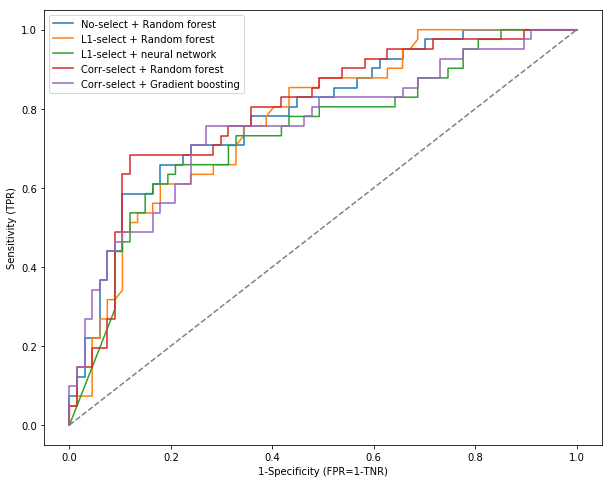

In [878]:
plt.figure(figsize=(10,8))


plt.plot(fpr_rfc, tpr_rfc, label='No-select + Random forest')

plt.plot(fpr_rfc_l1, tpr_rfc_l1, label='L1-select + Random forest')
plt.plot(fpr_nn_l1, tpr_nn_l1, label='L1-select + neural network')

plt.plot(fpr_rfc_cor, tpr_rfc_cor, label='Corr-select + Random forest')
#plt.plot(fpr_lr_cor, tpr_lr_cor, label = 'Corr-select + Logistic regression')
plt.plot(fpr_gbc_cor, tpr_gbc_cor, label = 'Corr-select + Gradient boosting')
#plt.plot(fpr_nn_cor, tpr_nn_cor, label = 'Corr-select + neural network')
plt.plot([0,1],[0,1],color='grey', linestyle='dashed')

plt.legend()
plt.ylabel("Sensitivity (TPR)")
plt.xlabel("1-Specificity (FPR=1-TNR)")